In [1]:
import numpy as np # 
import pandas as pd # 


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['plates.zip', 'sample_submission.csv']
After zip extraction:
['__MACOSX', 'plates', '__notebook__.ipynb']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))


['.DS_Store', 'test', 'train']


In [3]:
!ls

__MACOSX  __notebook__.ipynb  plates


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 6614.13it/s]


In [5]:
!ls 



__MACOSX  __notebook__.ipynb  plates  train  val


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(4, 32)

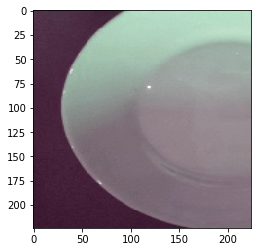

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

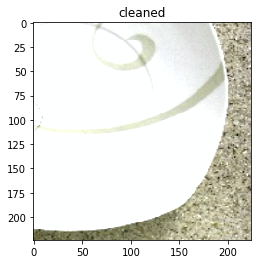

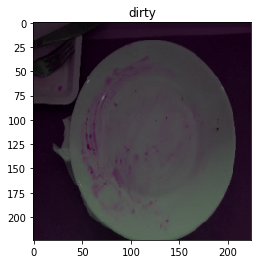

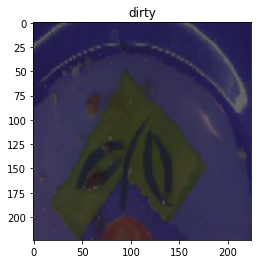

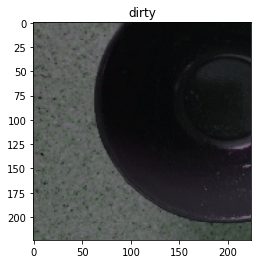

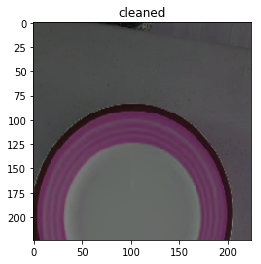

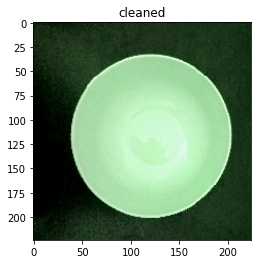

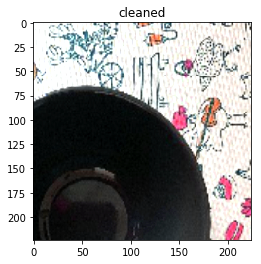

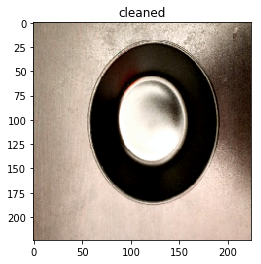

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
running_loss_stat = []
running_acc_stat = []
running_loss_stat_val = []

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.
            

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                
                accuracy = (preds_class == labels.data).float().mean()
                running_loss += loss_value.item()
                running_acc += accuracy
                
                

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            running_acc_stat.append(epoch_acc)
            
            if phase == "val":
                running_loss_stat_val.append(epoch_loss)
            else:
                running_loss_stat.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [12]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, amsgrad=True)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 19034621.33it/s]


In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

train Loss: 0.7895 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

val Loss: 0.8330 Acc: 0.3750
Epoch 1/99:



100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

train Loss: 0.7181 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

val Loss: 0.7325 Acc: 0.6250
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

train Loss: 0.6762 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

val Loss: 0.6793 Acc: 0.6250
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

train Loss: 0.5758 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

val Loss: 0.6266 Acc: 0.6250
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

train Loss: 0.6189 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.5846 Acc: 0.7500
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

train Loss: 0.6080 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.5575 Acc: 0.7500
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

train Loss: 0.6983 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

val Loss: 0.5617 Acc: 0.7500
Epoch 7/99:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.6428 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4937 Acc: 0.7500
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

train Loss: 0.5097 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.4725 Acc: 0.7500
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

train Loss: 0.5513 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

val Loss: 0.4615 Acc: 0.7500
Epoch 10/99:



100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

train Loss: 0.4561 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

val Loss: 0.4558 Acc: 0.8750
Epoch 11/99:



100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

train Loss: 0.5277 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.4649 Acc: 0.7500
Epoch 12/99:



100%|██████████| 4/4 [00:00<00:00,  7.46it/s]

train Loss: 0.6044 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.4659 Acc: 0.7500
Epoch 13/99:



100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

train Loss: 0.5854 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.4653 Acc: 0.7500
Epoch 14/99:



100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

train Loss: 0.5044 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

val Loss: 0.4575 Acc: 0.7500
Epoch 15/99:



100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

train Loss: 0.4745 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.4556 Acc: 0.7500
Epoch 16/99:



100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

train Loss: 0.5077 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

val Loss: 0.4707 Acc: 0.8750
Epoch 17/99:



100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

train Loss: 0.4601 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4801 Acc: 0.8750
Epoch 18/99:



100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

train Loss: 0.5471 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.4881 Acc: 0.8750
Epoch 19/99:



100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

train Loss: 0.5006 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

val Loss: 0.4861 Acc: 0.7500
Epoch 20/99:



100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

train Loss: 0.5176 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.4875 Acc: 0.7500
Epoch 21/99:



100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

train Loss: 0.4995 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

val Loss: 0.5018 Acc: 0.7500
Epoch 22/99:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.6063 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.4944 Acc: 0.6250
Epoch 23/99:



100%|██████████| 4/4 [00:00<00:00,  7.64it/s]

train Loss: 0.5819 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

val Loss: 0.4764 Acc: 0.7500
Epoch 24/99:



100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

train Loss: 0.4877 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

val Loss: 0.4638 Acc: 0.7500
Epoch 25/99:



100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

train Loss: 0.5023 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

val Loss: 0.4719 Acc: 0.7500
Epoch 26/99:



100%|██████████| 4/4 [00:00<00:00,  7.55it/s]

train Loss: 0.5393 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.4840 Acc: 0.7500
Epoch 27/99:



100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

train Loss: 0.5283 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

val Loss: 0.4817 Acc: 0.7500
Epoch 28/99:



100%|██████████| 4/4 [00:00<00:00,  7.52it/s]

train Loss: 0.6359 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

val Loss: 0.4661 Acc: 0.7500
Epoch 29/99:



100%|██████████| 4/4 [00:00<00:00,  7.55it/s]

train Loss: 0.5474 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.4645 Acc: 0.7500
Epoch 30/99:



100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

train Loss: 0.4917 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

val Loss: 0.4669 Acc: 0.8750
Epoch 31/99:



100%|██████████| 4/4 [00:00<00:00,  7.35it/s]

train Loss: 0.5161 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

val Loss: 0.4534 Acc: 0.7500
Epoch 32/99:



100%|██████████| 4/4 [00:00<00:00,  7.63it/s]

train Loss: 0.5594 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

val Loss: 0.4676 Acc: 0.7500
Epoch 33/99:



100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

train Loss: 0.5796 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.4612 Acc: 0.8750
Epoch 34/99:



100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

train Loss: 0.4434 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4674 Acc: 0.8750
Epoch 35/99:



100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

train Loss: 0.5864 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

val Loss: 0.4848 Acc: 0.6250
Epoch 36/99:



100%|██████████| 4/4 [00:00<00:00,  7.48it/s]

train Loss: 0.5131 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4826 Acc: 0.6250
Epoch 37/99:



100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

train Loss: 0.5502 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

val Loss: 0.4796 Acc: 0.7500
Epoch 38/99:



100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

train Loss: 0.5314 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.4785 Acc: 0.7500
Epoch 39/99:



100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

train Loss: 0.5050 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

val Loss: 0.4733 Acc: 0.8750
Epoch 40/99:



100%|██████████| 4/4 [00:00<00:00,  7.57it/s]

train Loss: 0.4875 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4674 Acc: 0.7500
Epoch 41/99:



100%|██████████| 4/4 [00:00<00:00,  7.40it/s]

train Loss: 0.4786 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

val Loss: 0.4580 Acc: 0.7500
Epoch 42/99:



100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

train Loss: 0.5179 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

val Loss: 0.4703 Acc: 0.7500
Epoch 43/99:



100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

train Loss: 0.5650 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4577 Acc: 0.7500
Epoch 44/99:



100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

train Loss: 0.5096 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

val Loss: 0.4695 Acc: 0.7500
Epoch 45/99:



100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

train Loss: 0.5046 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4875 Acc: 0.6250
Epoch 46/99:



100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

train Loss: 0.5182 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.5107 Acc: 0.6250
Epoch 47/99:



100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

train Loss: 0.5805 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

val Loss: 0.4837 Acc: 0.7500
Epoch 48/99:



100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

train Loss: 0.4776 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

val Loss: 0.4835 Acc: 0.6250
Epoch 49/99:



100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

train Loss: 0.5031 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

val Loss: 0.4840 Acc: 0.6250
Epoch 50/99:



100%|██████████| 4/4 [00:00<00:00,  6.38it/s]

train Loss: 0.5064 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

val Loss: 0.4777 Acc: 0.7500
Epoch 51/99:



100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

train Loss: 0.4851 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.4749 Acc: 0.8750
Epoch 52/99:



100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

train Loss: 0.4894 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.4678 Acc: 0.8750
Epoch 53/99:



100%|██████████| 4/4 [00:00<00:00,  7.54it/s]

train Loss: 0.5064 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4822 Acc: 0.8750
Epoch 54/99:



100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

train Loss: 0.5775 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

val Loss: 0.4944 Acc: 0.6250
Epoch 55/99:



100%|██████████| 4/4 [00:00<00:00,  7.70it/s]

train Loss: 0.5404 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4830 Acc: 0.7500
Epoch 56/99:



100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

train Loss: 0.5276 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.4952 Acc: 0.7500
Epoch 57/99:



100%|██████████| 4/4 [00:00<00:00,  7.60it/s]

train Loss: 0.4865 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

val Loss: 0.5049 Acc: 0.6250
Epoch 58/99:



100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

train Loss: 0.4967 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

val Loss: 0.5069 Acc: 0.6250
Epoch 59/99:



100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

train Loss: 0.5002 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4811 Acc: 0.8750
Epoch 60/99:



100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

train Loss: 0.3862 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

val Loss: 0.4737 Acc: 0.8750
Epoch 61/99:



100%|██████████| 4/4 [00:00<00:00,  7.64it/s]

train Loss: 0.4217 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

val Loss: 0.4787 Acc: 0.8750
Epoch 62/99:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.5154 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

val Loss: 0.4566 Acc: 0.8750
Epoch 63/99:



100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

train Loss: 0.5629 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

val Loss: 0.4623 Acc: 0.8750
Epoch 64/99:



100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

train Loss: 0.5671 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4581 Acc: 0.8750
Epoch 65/99:



100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

train Loss: 0.5163 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

val Loss: 0.4549 Acc: 0.7500
Epoch 66/99:



100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

train Loss: 0.4816 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.4686 Acc: 0.7500
Epoch 67/99:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 0.4728 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

val Loss: 0.4639 Acc: 0.7500
Epoch 68/99:



100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

train Loss: 0.5853 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.4610 Acc: 0.8750
Epoch 69/99:



100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

train Loss: 0.5492 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.4694 Acc: 0.7500
Epoch 70/99:



100%|██████████| 4/4 [00:00<00:00,  7.34it/s]

train Loss: 0.5240 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

val Loss: 0.4755 Acc: 0.7500
Epoch 71/99:



100%|██████████| 4/4 [00:00<00:00,  6.90it/s]

train Loss: 0.4757 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 0.4867 Acc: 0.6250
Epoch 72/99:



100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

train Loss: 0.5393 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

val Loss: 0.4937 Acc: 0.7500
Epoch 73/99:



100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

train Loss: 0.4605 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4958 Acc: 0.7500
Epoch 74/99:



100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

train Loss: 0.5137 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4927 Acc: 0.7500
Epoch 75/99:



100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

train Loss: 0.5321 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

val Loss: 0.4931 Acc: 0.6250
Epoch 76/99:



100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

train Loss: 0.4470 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

val Loss: 0.4946 Acc: 0.6250
Epoch 77/99:



100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

train Loss: 0.4557 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

val Loss: 0.4866 Acc: 0.7500
Epoch 78/99:



100%|██████████| 4/4 [00:00<00:00,  7.57it/s]

train Loss: 0.5530 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4813 Acc: 0.8750
Epoch 79/99:



100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

train Loss: 0.5493 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

val Loss: 0.4729 Acc: 0.7500
Epoch 80/99:



100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

train Loss: 0.4975 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.4734 Acc: 0.7500
Epoch 81/99:



100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

train Loss: 0.5258 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.4765 Acc: 0.7500
Epoch 82/99:



100%|██████████| 4/4 [00:00<00:00,  7.70it/s]

train Loss: 0.5322 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

val Loss: 0.4842 Acc: 0.7500
Epoch 83/99:



100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

train Loss: 0.5123 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.4811 Acc: 0.7500
Epoch 84/99:



100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

train Loss: 0.4957 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.4820 Acc: 0.7500
Epoch 85/99:



100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

train Loss: 0.5045 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.4710 Acc: 0.7500
Epoch 86/99:



100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

train Loss: 0.4837 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.4770 Acc: 0.8750
Epoch 87/99:



100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

train Loss: 0.5625 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.4755 Acc: 0.8750
Epoch 88/99:



100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

train Loss: 0.5391 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

val Loss: 0.4731 Acc: 0.8750
Epoch 89/99:



100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

train Loss: 0.5205 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

val Loss: 0.4717 Acc: 0.8750
Epoch 90/99:



100%|██████████| 4/4 [00:00<00:00,  7.63it/s]

train Loss: 0.5020 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.4652 Acc: 0.8750
Epoch 91/99:



100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

train Loss: 0.5108 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

val Loss: 0.4694 Acc: 0.8750
Epoch 92/99:



100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

train Loss: 0.4862 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.4791 Acc: 0.7500
Epoch 93/99:



100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

train Loss: 0.5172 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.4781 Acc: 0.7500
Epoch 94/99:



100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

train Loss: 0.4932 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.4727 Acc: 0.7500
Epoch 95/99:



100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

train Loss: 0.4869 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

val Loss: 0.4610 Acc: 0.8750
Epoch 96/99:



100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

train Loss: 0.6037 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

val Loss: 0.4773 Acc: 0.7500
Epoch 97/99:



100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

train Loss: 0.5810 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

val Loss: 0.4804 Acc: 0.7500
Epoch 98/99:



100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

train Loss: 0.5177 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

val Loss: 0.4748 Acc: 0.7500
Epoch 99/99:



100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

train Loss: 0.4358 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

val Loss: 0.4864 Acc: 0.7500


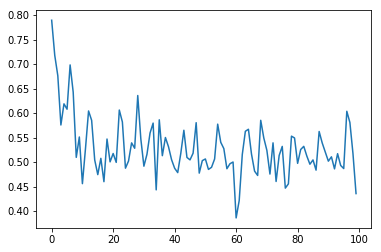

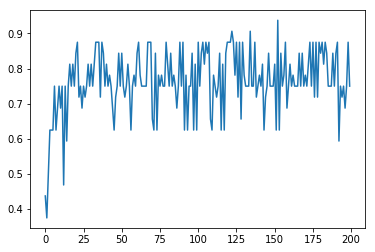

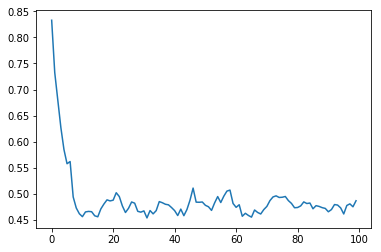

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(running_loss_stat, label="losstrain")
fig2, ax2 = plt.subplots()
ax2.plot(running_acc_stat)
fig3, ax3 = plt.subplots()
ax3.plot(running_loss_stat_val)




In [15]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [16]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [18]:
model.eval()

test_predictions = []
test_img_paths = []
inputs = []
labels = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)
    

100%|██████████| 93/93 [00:03<00:00, 27.26it/s]


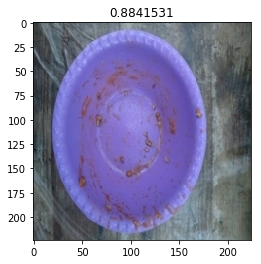

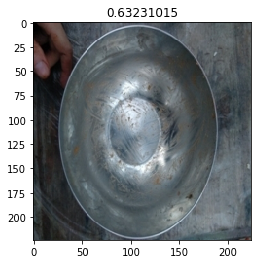

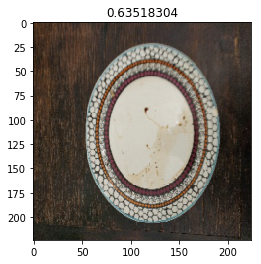

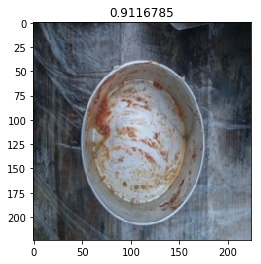

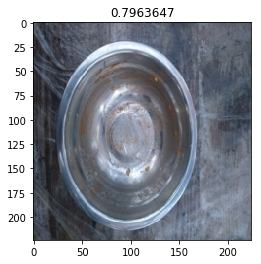

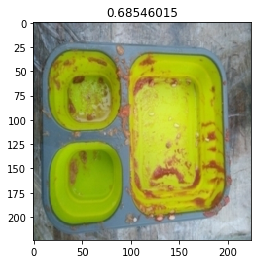

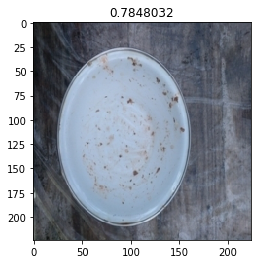

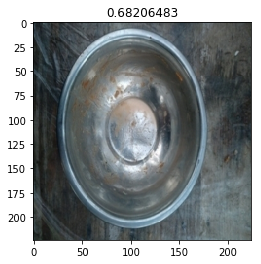

In [19]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [20]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [21]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=12)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


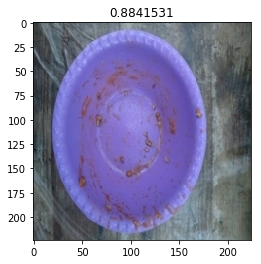

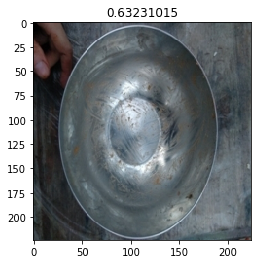

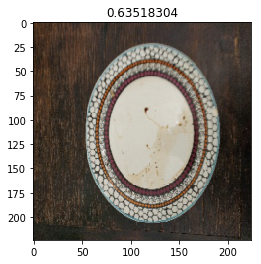

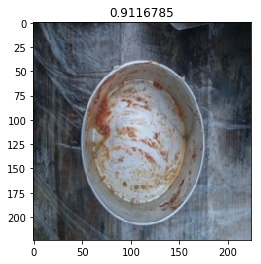

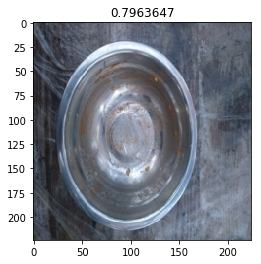

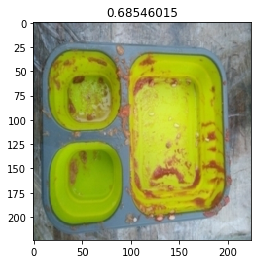

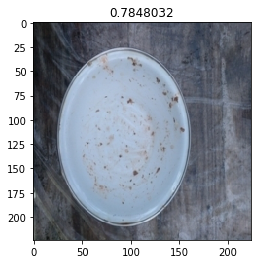

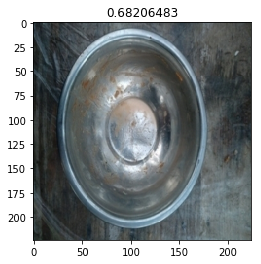

In [22]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [23]:
submission_df.to_csv('submission.csv')